In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import time

In [2]:
def CN_heat_2d(true_n,true_t,beta,f,u):

    


    delta_x=1/(true_n-1)

    x=np.linspace(0,1,true_n)


    

    t_index=np.linspace(0,1,true_t)
    #print(t_index)

    delta_t=1/(true_t-1)



    


    sol=np.zeros((true_t,true_n*true_n))
    
    ij_2_i=lambda i,j: i*true_n+j


    for i in range(0,true_n):
        for j in range(0,true_n):
            sol[0,ij_2_i(i,j)]=u(x[i],x[j],0)


    for t in range(1,true_t):

        for i in range(0,true_n):
            sol[t,ij_2_i(i,0)]=u(x[i],x[0],t_index[t])

            sol[t,ij_2_i(i,true_n-1)]=u(x[i],x[true_n-1],t_index[t])


            sol[t,ij_2_i(0,i)]=u(x[0],x[i],t_index[t])


            sol[t,ij_2_i(true_n-1,i)]=u(x[true_n-1],x[i],t_index[t])

    n_aux=true_n-2
    
    A=np.zeros((n_aux*n_aux,n_aux*n_aux))
    mu=beta*delta_t/(delta_x)**2

    ij_2_i_aux=lambda i,j: i*n_aux+j
    i_2_ij_aux=lambda i: (int(i/n_aux),i%n_aux)
    
    #crank nickelson A matrix
    for k in range(0,n_aux*n_aux):

        i,j=i_2_ij_aux(k)
        A[k,ij_2_i_aux(i,j)]=(1+2*mu)
        #boundary points-> no include
        if not i==n_aux-1:
            A[k,ij_2_i_aux(i+1,j)]=-mu/2
        if not i==0:
            A[k,ij_2_i_aux(i-1,j)]=-mu/2
        if not j==n_aux-1:
            A[k,ij_2_i_aux(i,j+1)]=-mu/2
        if not j==0:
            A[k,ij_2_i_aux(i,j-1)]=-mu/2

    for t in range(0,true_t-1):
        #crank nickelson F "matrix"
        F=np.zeros((n_aux*n_aux))
        for k in range(0,n_aux*n_aux):
            #+1+1

            F[k]=0.0

            i,j=i_2_ij_aux(k)

            F[k]+=(1-2*mu)*sol[t,ij_2_i(i+1,j+1)]

            F[k]+=0.5*delta_t*(f(x[i+1],x[j+1],t_index[t])+f(x[i+1],x[j+1],t_index[t+1]))

            F[k]+=(0.5*mu)*sol[t,ij_2_i(i+2,j+1)]
            F[k]+=(0.5*mu)*sol[t,ij_2_i(i,j+1)]
            F[k]+=(0.5*mu)*sol[t,ij_2_i(i+1,j+2)]
            F[k]+=(0.5*mu)*sol[t,ij_2_i(i+1,j)]

            #boundary points-> include them in F
            if i==n_aux-1:
                F[k]+=(0.5*mu)*sol[t+1,ij_2_i(i+2,j+1)]
            if i==0:
                F[k]+=(0.5*mu)*sol[t+1,ij_2_i(i,j+1)]
            if j==n_aux-1:
                F[k]+=(0.5*mu)*sol[t+1,ij_2_i(i+1,j+2)]
            if j==0:
                F[k]+=(0.5*mu)*sol[t+1,ij_2_i(i+1,j)]

        sol_aux=np.linalg.solve(A,F)

        for i in range(0,n_aux*n_aux):
            i_aux,j_aux=i_2_ij_aux(i)
            sol[t+1,ij_2_i(i_aux+1,j_aux+1)]=sol_aux[i]
    return sol


In [3]:
def ADI(true_n,true_t,beta,f,u):
    
    delta_x=1/(true_n-1)

    x=np.linspace(0,1,true_n)

    #-1 in pratical terms for it to do the 2 steps)
    true_t=true_t*2-1
    t_index=np.linspace(0,1,true_t)

    delta_t=1/(true_t-1)

    sol=np.zeros((true_t,true_n*true_n))
    
    ij_2_i=lambda i,j: i*true_n+j


    for i in range(0,true_n):
        for j in range(0,true_n):
            sol[0,ij_2_i(i,j)]=u(x[i],x[j],0)


    for t in range(1,true_t):

        for i in range(0,true_n):
            sol[t,ij_2_i(i,0)]=u(x[i],x[0],t_index[t])

            sol[t,ij_2_i(i,true_n-1)]=u(x[i],x[true_n-1],t_index[t])


            sol[t,ij_2_i(0,i)]=u(x[0],x[i],t_index[t])


            sol[t,ij_2_i(true_n-1,i)]=u(x[true_n-1],x[i],t_index[t])

    n_aux=true_n-2
    
    mu=beta*delta_t/(delta_x)**2

    ij_2_i_aux=lambda i,j: i*n_aux+j
    i_2_ij_aux=lambda i: (int(i/n_aux),i%n_aux)
    
    
    A_1=np.zeros((n_aux*n_aux,n_aux*n_aux))

    #ADI 1st A matrix
    for k in range(0,n_aux*n_aux):

        i,j=i_2_ij_aux(k)
        A_1[k,ij_2_i_aux(i,j)]=(1+2*mu)
        #boundary points-> no include
        if not i==n_aux-1:
            A_1[k,ij_2_i_aux(i+1,j)]=-mu
        if not i==0:
            A_1[k,ij_2_i_aux(i-1,j)]=-mu

            
    
    A_2=np.zeros((n_aux*n_aux,n_aux*n_aux))

    #ADI 2nd A matrix
    for k in range(0,n_aux*n_aux):

        i,j=i_2_ij_aux(k)
        A_2[k,ij_2_i_aux(i,j)]=(1+2*mu)
        #boundary points-> no include
        if not j==n_aux-1:
            A_2[k,ij_2_i_aux(i,j+1)]=-mu
        if not j==0:
            A_2[k,ij_2_i_aux(i,j-1)]=-mu


    for t in range(0,true_t-1):

        if(t%2==0):
            F=np.zeros((n_aux*n_aux))

            for k in range(0,n_aux*n_aux):
                #+1+1

                F[k]=0.0

                i,j=i_2_ij_aux(k)

                F[k]+=(1-2*mu)*sol[t,ij_2_i(i+1,j+1)]+mu*(sol[t,ij_2_i(i+1,j+2)]+sol[t,ij_2_i(i+1,j)])
                
                F[k]+=f(x[i+1],x[j+1],t_index[t+1])*delta_t
                #boundary points-> include them in F
                if i==n_aux-1:
                    F[k]+=(mu)*sol[t+1,ij_2_i(i+2,j+1)]
                if i==0:
                    F[k]+=(mu)*sol[t+1,ij_2_i(i,j+1)]
                    
            sol_aux=np.linalg.solve(A_1,F)
        else:
            F=np.zeros((n_aux*n_aux))
            for k in range(0,n_aux*n_aux):
                #+1+1
                
                F[k]=0.0

                i,j=i_2_ij_aux(k)

                F[k]+=(1-2*mu)*sol[t,ij_2_i(i+1,j+1)]+mu*(sol[t,ij_2_i(i+2,j+1)]+sol[t,ij_2_i(i,j+1)])
                F[k]+=f(x[i+1],x[j+1],t_index[t])*delta_t
                #boundary points-> include them in F
                if j==n_aux-1:
                    F[k]+=(mu)*sol[t+1,ij_2_i(i+1,j+2)]
                if j==0:
                    F[k]+=(mu)*sol[t+1,ij_2_i(i+1,j)]
                    
            sol_aux=np.linalg.solve(A_2,F)

                

        for i in range(0,n_aux*n_aux):
            i_aux,j_aux=i_2_ij_aux(i)
            sol[t+1,ij_2_i(i_aux+1,j_aux+1)]=sol_aux[i]
    #only return time slices with pair indexes
    return sol[::2,:]
    



In [4]:
def exact_heat_2d(true_n,true_t,beta,f,u):
    ij_2_i=lambda i,j: i*true_n+j
    sol_aux=np.zeros((true_t,true_n*true_n))
    x=np.linspace(0,1,true_n)
    t_index=np.linspace(0,1,true_t)
    for t in range(0,true_t):
        for i in range(0,true_n):
                for j in range(0,true_n):
                    sol_aux[t,ij_2_i(i,j)]=u(x[i],x[j],t_index[t])
    return sol_aux

In [5]:
def norm_array(sol,exact,order=2):
    ret=np.zeros(sol.shape[0])
    for i in range(0,sol.shape[0] ):
        ret[i]=np.sqrt(np.linalg.norm(sol[i,:]-exact[i,:],ord=order))/sol.shape[1]
    return ret

beta=1
u=lambda x,y,t: (1+t)*(x**2+y**2)
f=lambda x,y,t: (x**2+y**2)-4*beta*(1+t)

In [6]:

true_n=11
true_t=11


t_1=np.linspace(0,1,true_t)
exact_1=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_1=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/10",time.time()-time_aux)

time_aux=time.time()
adi_1=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/10",time.time()-time_aux)

true_t=51
t_2=np.linspace(0,1,true_t)

exact_2=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_2=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/50",time.time()-time_aux)

time_aux=time.time()
adi_2=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/50",time.time()-time_aux)


true_t=101
t_3=np.linspace(0,1,true_t)

exact_3=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_3=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/100",time.time()-time_aux)

time_aux=time.time()
adi_3=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/100",time.time()-time_aux)


Time CN h=1/10 dt=1/10 0.016933679580688477
Time ADI h=1/10 dt=1/10 0.01495981216430664
Time CN h=1/10 dt=1/50 0.06183600425720215
Time ADI h=1/10 dt=1/50 0.07184815406799316
Time CN h=1/10 dt=1/100 0.11963009834289551
Time ADI h=1/10 dt=1/100 0.1635599136352539


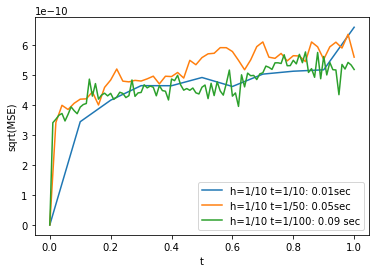

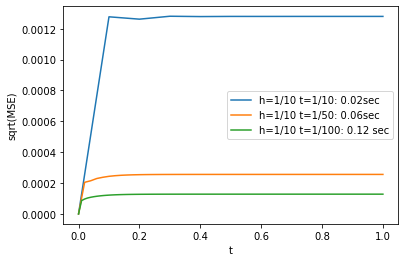

Text(0.5, 0, 'u(x,y,1)')

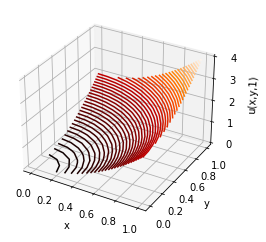

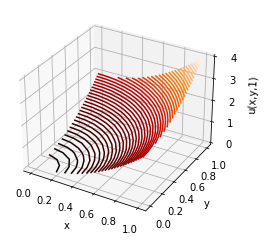

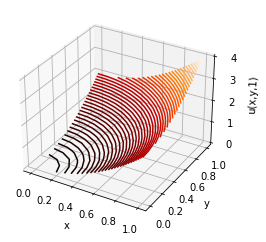

In [7]:

plt.plot(t_1,norm_array(cn_1,exact_1))
plt.plot(t_2,norm_array(cn_2,exact_2))
plt.plot(t_3,norm_array(cn_3,exact_3))
plt.legend(["h=1/10 t=1/10: 0.01sec","h=1/10 t=1/50: 0.05sec","h=1/10 t=1/100: 0.09 sec"])
plt.xlabel("t")
plt.ylabel("sqrt(MSE)")
plt.show()

plt.plot(t_1,norm_array(adi_1,exact_1))
plt.plot(t_2,norm_array(adi_2,exact_2))
plt.plot(t_3,norm_array(adi_3,exact_3))
plt.legend(["h=1/10 t=1/10: 0.02sec","h=1/10 t=1/50: 0.06sec","h=1/10 t=1/100: 0.12 sec"])
plt.xlabel("t")
plt.ylabel("sqrt(MSE)")
plt.show()

exact=np.reshape(exact_3, (true_t,true_n,true_n))[-1]
cn_3=np.reshape(cn_3, (true_t,true_n,true_n))[-1]
adi_3=np.reshape(adi_3, (true_t,true_n,true_n))[-1]

y = np.linspace(0,1,true_n)
x = np.linspace(0,1,true_n)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, exact, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y,1)')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, cn_3, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y,1)')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, adi_3, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y,1)')

In [8]:
beta=1

true_n=51
true_t=11


t_1=np.linspace(0,1,true_t)
exact_1=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_1=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/10",time.time()-time_aux)

time_aux=time.time()
adi_1=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/10",time.time()-time_aux)

true_t=51
t_2=np.linspace(0,1,true_t)

exact_2=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_2=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/50",time.time()-time_aux)

time_aux=time.time()
adi_2=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/50",time.time()-time_aux)


true_t=101
t_3=np.linspace(0,1,true_t)

exact_3=exact_heat_2d(true_n,true_t,beta,f,u)

time_aux=time.time()
cn_3=CN_heat_2d(true_n,true_t,beta,f,u)
print("Time CN h=1/10 dt=1/100",time.time()-time_aux)

time_aux=time.time()
adi_3=ADI(true_n,true_t,beta,f,u)
print("Time ADI h=1/10 dt=1/100",time.time()-time_aux)

Time CN h=1/10 dt=1/10 2.2240190505981445
Time ADI h=1/10 dt=1/10 4.471045255661011
Time CN h=1/10 dt=1/50 13.915790557861328
Time ADI h=1/10 dt=1/50 21.454150676727295
Time CN h=1/10 dt=1/100 23.480039834976196
Time ADI h=1/10 dt=1/100 48.65395212173462


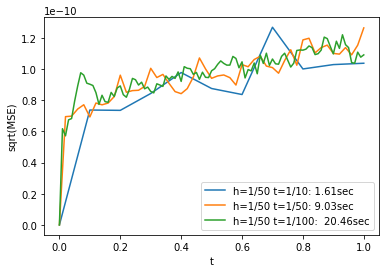

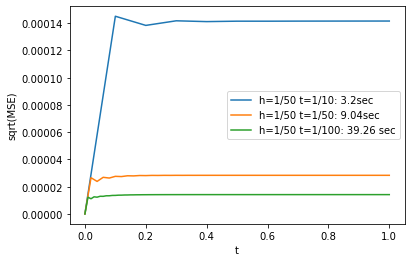

Text(0.5, 0, 'u(x,y,1)')

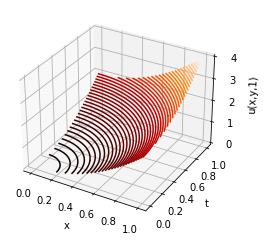

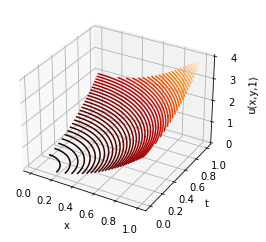

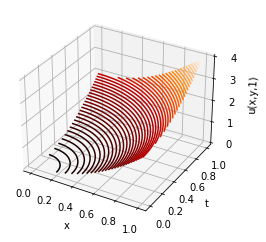

In [9]:

plt.plot(t_1,norm_array(cn_1,exact_1))
plt.plot(t_2,norm_array(cn_2,exact_2))
plt.plot(t_3,norm_array(cn_3,exact_3))
plt.legend(["h=1/50 t=1/10: 1.61sec","h=1/50 t=1/50: 9.03sec","h=1/50 t=1/100:  20.46sec"])
plt.xlabel("t")
plt.ylabel("sqrt(MSE)")
plt.show()

plt.plot(t_1,norm_array(adi_1,exact_1))
plt.plot(t_2,norm_array(adi_2,exact_2))
plt.plot(t_3,norm_array(adi_3,exact_3))
plt.legend(["h=1/50 t=1/10: 3.2sec","h=1/50 t=1/50: 9.04sec","h=1/50 t=1/100: 39.26 sec"])
plt.xlabel("t")
plt.ylabel("sqrt(MSE)")
plt.show()

exact=np.reshape(exact_3, (true_t,true_n,true_n))[-1]
cn_3=np.reshape(cn_3, (true_t,true_n,true_n))[-1]
adi_3=np.reshape(adi_3, (true_t,true_n,true_n))[-1]

y = np.linspace(0,1,true_n)
x = np.linspace(0,1,true_n)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, exact, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,y,1)')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, cn_3, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,y,1)')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, adi_3, 50, cmap='gist_heat')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,y,1)')